# Synthetic Dataset Simulating the 3D Resistivity Inverted Model from EarthStar

In [17]:
import sys
import pickle

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# libs for image processing
import cv2
from scipy.ndimage import gaussian_filter, laplace
from scipy import ndimage, interpolate
from PIL import Image, ImageEnhance

#### Initial Data Loading

In [18]:
image_path = 'MWDLWD-SLB-cleaned.png'
img = mpimg.imread(image_path)

In [19]:
#### Processing of the image, converting from RGB to Gray

In [20]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [21]:
gray = rgb2gray(img)

In [22]:
#additional processing of 
gray = 1-gray
gray[gray == 1] -= 1
main_arr = gray*50

In [23]:
# Universal Plotting function
def plot(array, title = 'Resistivity',
         x_label = 'Distance /10 [m]',
         y_label = 'Depth /10 [m]',
         size = (20,5),
         vmin=0, vmax=50):
    fig, ax = plt.subplots()
    fig.set_size_inches(size)
    plt.title(f'{title}')
    plt.xlabel(f'{x_label}')
    plt.ylabel(f'{y_label}')
    shw = ax.imshow(array,
                    aspect='auto',
                    interpolation = 'nearest',
                    cmap = plt.get_cmap('gist_rainbow_r'),
                    vmin=0, vmax=50)
    bar = plt.colorbar(shw)
    bar.set_label('Resistivity')
    bar.set_label('Rt [Ohm*m]')

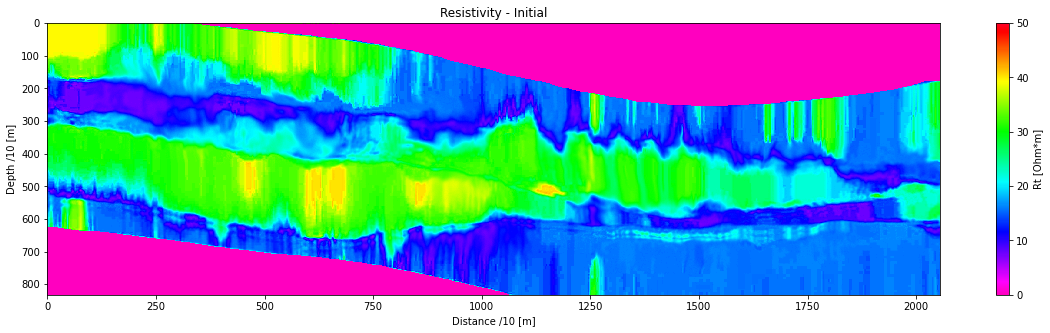

In [24]:
plot(main_arr, title = 'Resistivity - Initial')

#### Synthetic data creating

In [25]:
# Gaussian filtrating
image_first_derivative = gaussian_filter(main_arr, sigma=20)

In [26]:
#noising
for n in range (100):
    sampl_noize = np.random.uniform(low=n/(n**2+1), high=(n+2)/(n**2+1), size=(833, 2055))
    image_first_derivative+=sampl_noize
    sampl_noize = np.random.uniform(low=n/(n**2+1), high=(n+2)/(n**2+1), size=(833, 2055))
    image_first_derivative-=sampl_noize    
image_first_derivative = abs(image_first_derivative)
image_first_derivative[image_first_derivative > 0] -= 5

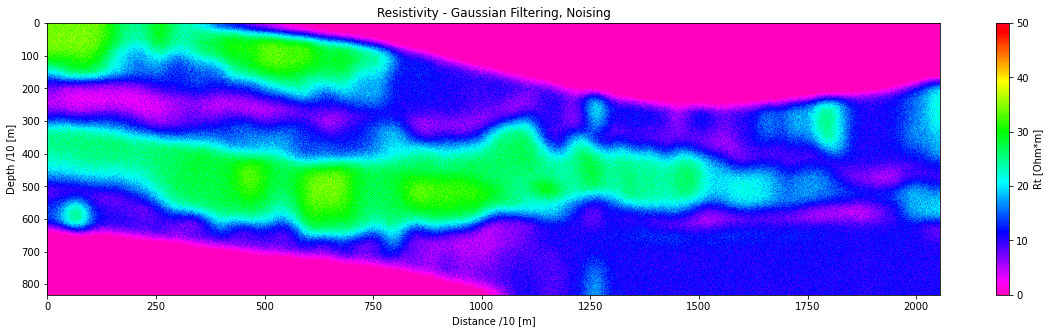

In [27]:
plot(image_first_derivative, title = 'Resistivity - Gaussian Filtering, Noising')

In [28]:
# prepared kernel for cv2.filter2D
kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])

#### Synthetic section 1

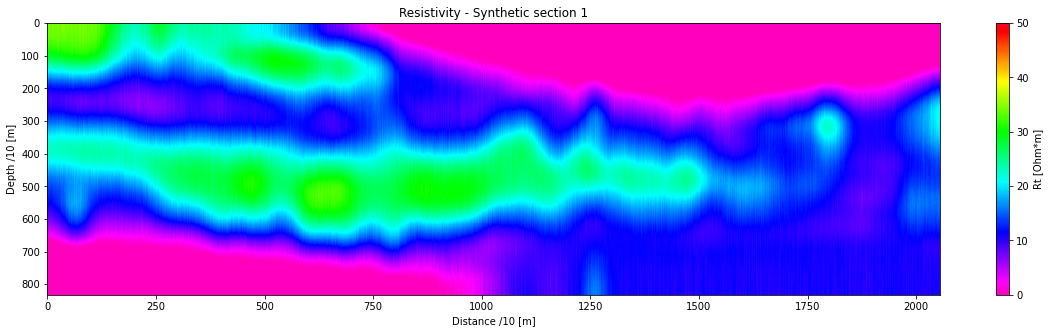

In [29]:
# a uniform (boxcar) filter with a width of 50
SS1 = ndimage.uniform_filter1d(image_first_derivative, 150, 0)
SS1 = cv2.filter2D(src=SS1, ddepth=-25, kernel=kernel)
plot(SS1, title = 'Resistivity - Synthetic section 1')

#### Synthetic section 2

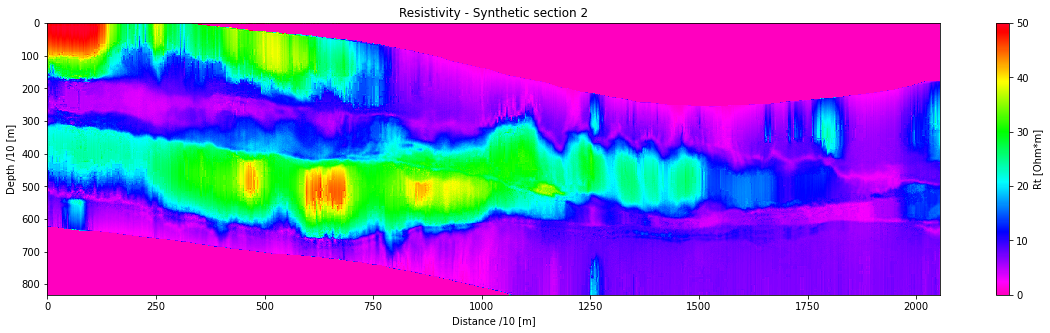

In [30]:
# a Gaussian filter with a standard deviation of 10
SS2 = ndimage.gaussian_filter1d(image_first_derivative, 90, 0)*main_arr/(np.mean(main_arr)*1.5)
SS2 = cv2.filter2D(src=SS2, ddepth=-25, kernel=kernel)
plot(SS2, title = 'Resistivity - Synthetic section 2')

#### Synthetic section 3

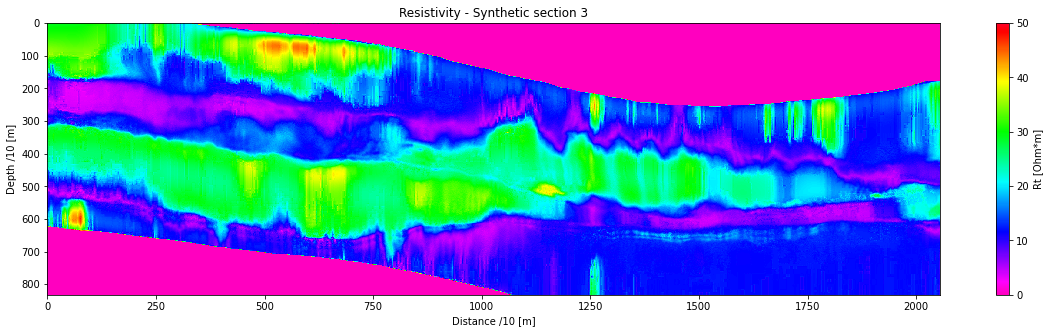

In [31]:
SS3=((-SS1 + main_arr)*3+30)/60
SS3 = gaussian_filter(SS3, sigma=22)*main_arr
SS3 = cv2.filter2D(src=SS3, ddepth=-25, kernel=kernel)
plot(SS3, title = 'Resistivity - Synthetic section 3')

#### Synthetic section 4

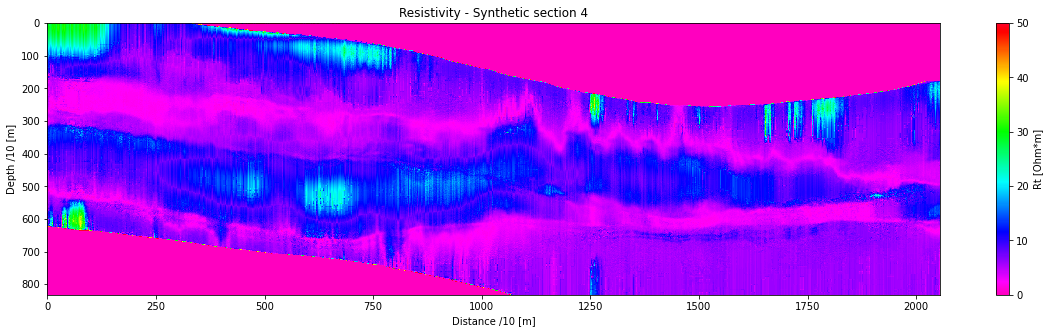

In [32]:
SS4 = (abs(SS3-SS2)+10)*main_arr/40
SS4 = ndimage.uniform_filter1d(SS4, 1, 0)
SS4 = cv2.filter2D(src=SS4, ddepth=-25, kernel=kernel)
plot(SS4, title = 'Resistivity - Synthetic section 4')

#### Synthetic section 5

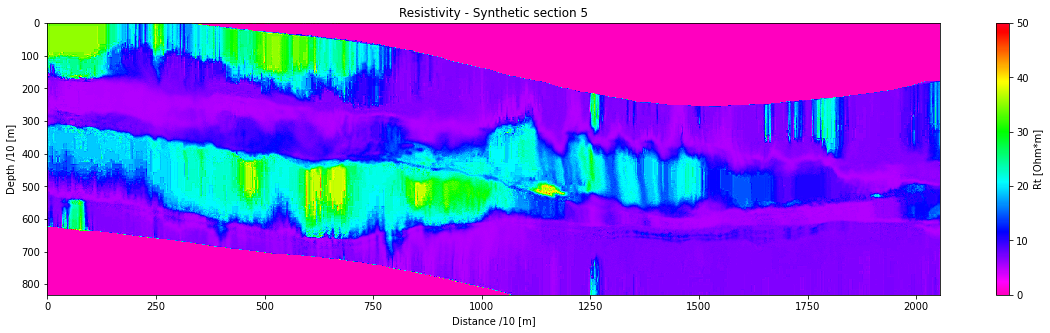

In [34]:
SS5 = (4*(main_arr)**3-((main_arr)**2+1/3*main_arr))/8000
SS5[SS5 > 0] += 5
SS5 = cv2.filter2D(src=SS5, ddepth=-25, kernel=kernel)
plot(SS5,title = 'Resistivity - Synthetic section 5')

#### Synthetic section 6

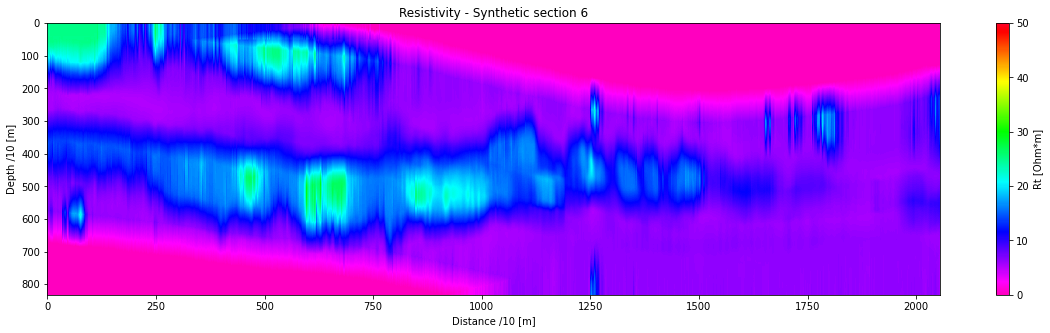

In [35]:
SS6 = (4*(main_arr)**3-((main_arr)**2+1/3*main_arr))/12000
SS6[SS6 > 0] +=5
SS6 = ndimage.uniform_filter1d(SS6, 100, 0)
SS6 = cv2.filter2D(src=SS6, ddepth=-25, kernel=kernel)
plot(SS6, title = 'Resistivity - Synthetic section 6')

## 3D - Staking 2D sections into 3D cube with interpolation

In [36]:
empty_3d = np.empty([49,833,2055])
empty_3d[:] = np.nan

arr_3D = np.vstack([SS5[None,:], empty_3d])
arr_3D = np.vstack([arr_3D, SS3[None,:]])
arr_3D = np.vstack([arr_3D, empty_3d])
arr_3D = np.vstack([arr_3D, main_arr[None,:]])
arr_3D = np.vstack([arr_3D, empty_3d])
arr_3D = np.vstack([arr_3D, SS1[None,:]])
arr_3D = np.vstack([arr_3D, empty_3d])
arr_3D = np.vstack([arr_3D, SS2[None,:]])
arr_3D = np.vstack([arr_3D, empty_3d])
arr_3D = np.vstack([arr_3D, SS6[None,:]])
arr_3D = np.vstack([arr_3D, empty_3d])
arr_3D = np.vstack([arr_3D, SS4[None,:]])

In [37]:
volume = np.empty([0,len(arr_3D),len(arr_3D[0,:])])


for n in range(len(arr_3D[0,0,:])):
# for n in range(6):
    array = arr_3D[:,:,n]
    x = np.arange(0, array.shape[1])
    y = np.arange(0, array.shape[0])
    #mask invalid values
    array = np.ma.masked_invalid(arr_3D[:,:,n])
    xx, yy = np.meshgrid(x, y)
    #get only the valid values
    x1 = xx[~array.mask]
    y1 = yy[~array.mask]
    newarr = array[~array.mask]

    int_section = interpolate.griddata((x1, y1), newarr.ravel(),
                          (xx, yy),
                             method='cubic')
    volume = np.vstack([volume,int_section[None,:]])
    

In [38]:

volume.shape


(2055, 301, 833)

In [39]:
volume = np.einsum('kli->lik', volume)
volume.shape


(301, 833, 2055)

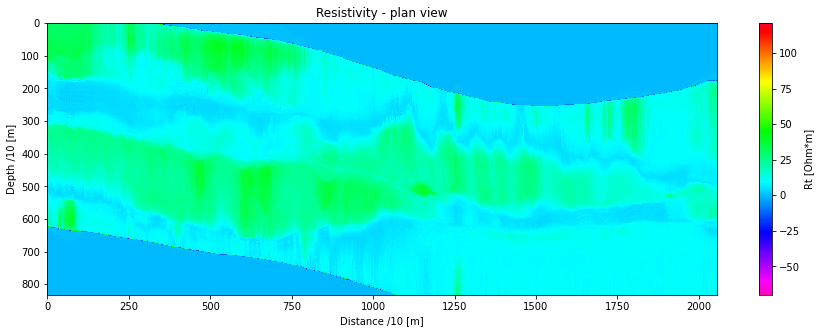

In [40]:
fig1, ax = plt.subplots()
fig1.set_size_inches(15,5)
plt.title('Resistivity - plan view')
plt.xlabel('Distance /10 [m]')
plt.ylabel('Depth /10 [m]')
shw1 = ax.imshow(volume[25,:,:],
                 aspect='auto',
                 interpolation = 'nearest',
                 cmap = plt.get_cmap('gist_rainbow_r'))
bar = plt.colorbar(shw1)
bar.set_label('Resistivity')
bar.set_label('Rt [Ohm*m]')

In [44]:
volume[25,:,:].shape

(833, 2055)

In [42]:
file="3D_37.833.2055.pickle"

with open(file,'wb') as f:
    pickle.dump(volume,f)